# Original YOLOv8 Model for Burned Area Segmentation

## 📌 Notebook Structure:

1. **Requirements and Imports**: Setting up the environment.
2. **Model Definition**: Import model.
3. **Training Function**: Implementation of the training loop.
4. **Validation Function**: Customized validation function.
5. **Training**: Initiating the model training process.
6. **Validation and Testing**: Evaluating model performance.
7.  **Visualize Results**: Displaying segmentation results visually.

In [ ]:
### INSTALL
!pip install ultralytics

In [2]:
### REQUIREMENTS
from ultralytics import YOLO
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
### MODEL
model = YOLO('yolov8m-seg.pt')
load = True
if load:
    model = YOLO('/content/drive/MyDrive/ResearchProject/models/yolov8/train7/weights/best.pt')
    # Best perform model
    # model = YOLO('/content/drive/MyDrive/ResearchProject/codes/YOLOv8/segmentation/train10/weights/best.pt')

In [4]:
### DATASET

### already organized in Google Drive for YOLO training

In [5]:
### TRAINING LOOP
model.train(
    data='/content/drive/MyDrive/ResearchProject/models/yolov8/config.yaml',
    epochs=500,
    patience=100,
    imgsz=512,
    device='cuda',
    batch=64,
    project='/content/drive/MyDrive/ResearchProject/models/yolov8',
    )

In [6]:
### VALIDATION LOOP
def get_f1(label, predict):
    # dice acc
    predict = (predict > 0.5).astype(np.float32)

    intersection = (predict * label).sum()

    f1_acc = (2 * intersection) / (label.sum() + predict.sum() + 1e-8)

    return f1_acc

def get_iou(label, predict):
    predict = (predict > 0.5).astype(np.float32)

    intersection = (predict * label).sum()
    union = label.sum() + predict.sum() - intersection

    return (intersection + 1e-8) / (union + 1e-8)


def get_mcc(label, predict):
    predict = (predict > 0.5).astype(np.float32)

    tp = (predict * label).sum()
    fp = (predict * (1 - label)).sum()
    fn = ((1 - predict) * label).sum()
    tn = ((1 - predict) * (1 - label)).sum()

    numerator = tp * tn - fp * fn
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    return numerator / (denominator + 1e-8)

def pred_yolo(input, model):
    # Get predictions
    results = model(input, )

    # Process results list
    pred = results[0].masks

    if results[0].masks is None:
        return np.zeros((512, 512), dtype=np.uint8)

    # Convert masks to CPU and then to numpy array
    pred_mask = pred.cpu().data

    pred_mask = pred_mask.numpy()

    merged_pred = pred_mask.max(axis=0)
    return merged_pred

def validate_yolo(val_mask, pred_mask, show=False):

    # Compute metrics
    f1_val = get_f1(val_mask, pred_mask)
    iou_val = get_iou(val_mask, pred_mask)
    mcc_val = get_mcc(val_mask, pred_mask)

    if show:
        # Print results
        print(f'Dice Score: {f1_val:.4f}')
        print(f'IoU: {iou_val:.4f}')
        print(f'MCC: {mcc_val:.4f}')

    return f1_val, iou_val, mcc_val



In [ ]:
### TESTING LOOP

images_src = '/content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/yolov8/images/test'
labels_src = '/content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/masks/test_masks'

imgs = list(Path(images_src).glob("**/*.jpeg"))
masks = list(Path(labels_src).glob("**/*.jpeg"))

imgs = {img.stem: img for img in imgs}
data = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]

avg_f1 = 0
avg_iou = 0
avg_mcc = 0

print(len(data))

n = 0

for image_path, mask_path in tqdm(data):

    true_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    true_binary_mask = (true_mask > 127).astype(np.uint8)

    if true_binary_mask.sum() == 0:
        continue

    pred_mask = pred_yolo(image_path, model)
    pred_binary_mask = (pred_mask > 0.5).astype(np.uint8)

    f1_val, iou_val,mcc_val = validate_yolo(true_binary_mask, pred_binary_mask, show=False)

    avg_f1 += f1_val
    avg_iou += iou_val
    avg_mcc += mcc_val

    n += 1

avg_f1 /= n
avg_iou /= n
avg_mcc /= n

print(f'\nAverage F1: {avg_f1:.4f}')
print(f'Average IoU: {avg_iou:.4f}')
print(f'Average MCC: {avg_mcc:.4f}')

  0%|          | 0/6 [00:00<?, ?it/s]
image 1/1 /content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/yolov8/images/visual_check/bbox_129_2020-01-19_to_2020-01-24_0.jpeg: 512x512 11 BAs, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


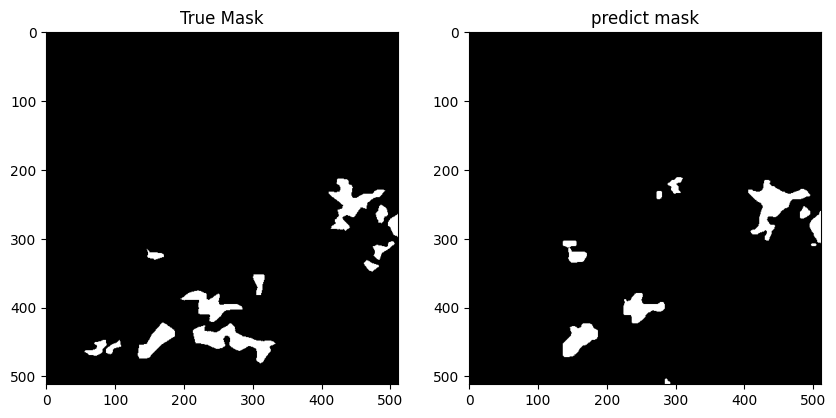

 17%|█▋        | 1/6 [00:00<00:02,  2.16it/s]
image 1/1 /content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/yolov8/images/visual_check/bbox_129_2020-01-14_to_2020-01-19_0.jpeg: 512x512 1 BA, 10.4ms
Speed: 1.3ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


F1-score: 0.5876


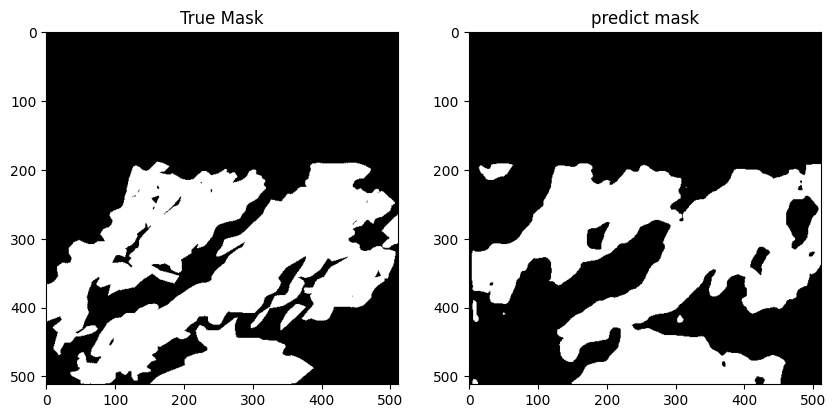

 33%|███▎      | 2/6 [00:00<00:01,  2.15it/s]
image 1/1 /content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/yolov8/images/visual_check/bbox_102_2020-01-14_to_2020-01-19_0.jpeg: 512x512 5 BAs, 9.6ms
Speed: 1.3ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


F1-score: 0.8027


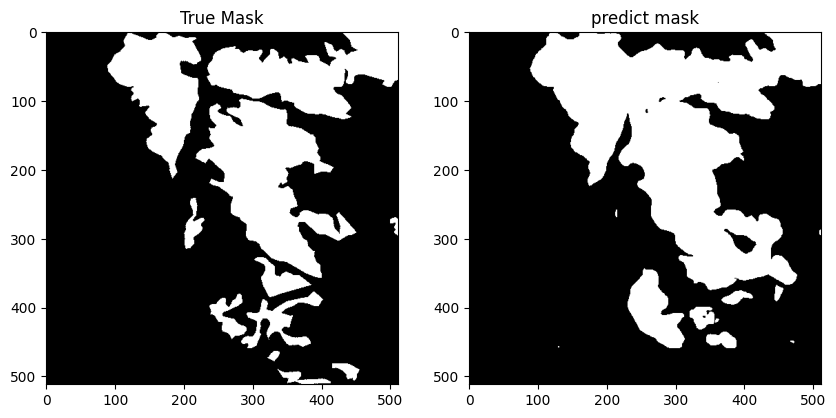

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]
image 1/1 /content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/yolov8/images/visual_check/bbox_102_2020-01-09_to_2020-01-14_0.jpeg: 512x512 3 BAs, 16.3ms
Speed: 1.5ms preprocess, 16.3ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 512)


F1-score: 0.8469


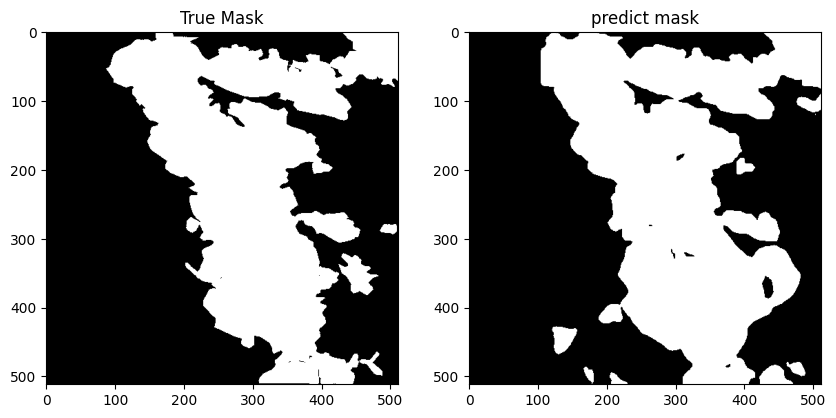

 67%|██████▋   | 4/6 [00:01<00:00,  2.06it/s]
image 1/1 /content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/yolov8/images/visual_check/bbox_148_2019-12-20_to_2019-12-25_0.jpeg: 512x512 3 BAs, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


F1-score: 0.9239


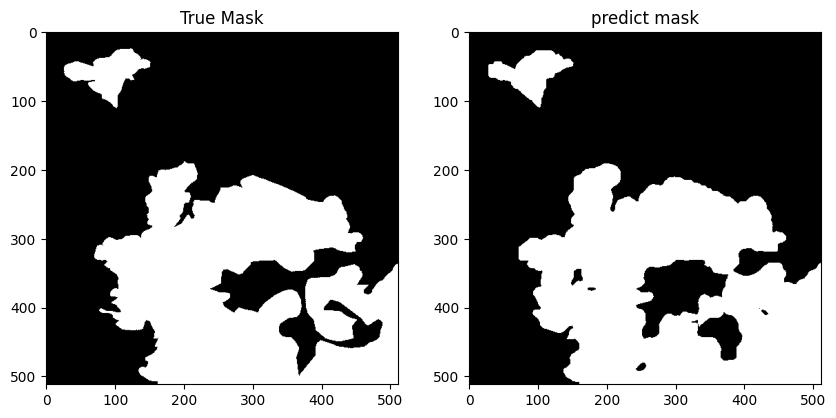

 83%|████████▎ | 5/6 [00:02<00:00,  2.10it/s]
image 1/1 /content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/yolov8/images/visual_check/bbox_148_2019-12-05_to_2019-12-10_0.jpeg: 512x512 3 BAs, 10.7ms
Speed: 1.3ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


F1-score: 0.9487


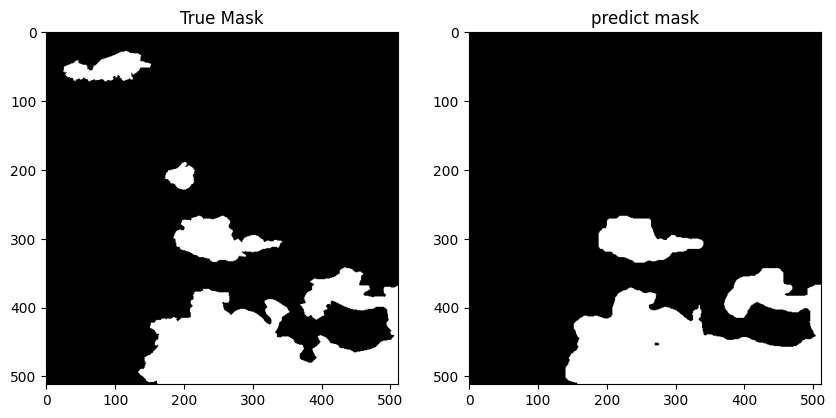

100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

F1-score: 0.9074

Average F1: 0.8362
Average IoU: 0.7354
Average MCC: 0.7925


In [8]:
### VISUALIZATION

images_src = '/content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/yolov8/images/visual_check'
labels_src = '/content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset/masks/test_masks'

imgs = list(Path(images_src).glob("**/*.jpeg"))
masks = list(Path(labels_src).glob("**/*.jpeg"))

imgs = {img.stem: img for img in imgs}
data = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]

avg_f1 = 0
avg_iou = 0
avg_mcc = 0

n = 0

for image_path, mask_path in tqdm(data):

    true_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    true_binary_mask = (true_mask > 127).astype(np.uint8)

    pred_mask = pred_yolo(image_path, model)
    pred_binary_mask = (pred_mask > 0.5).astype(np.uint8)

    f1_val, iou_val,mcc_val = validate_yolo(true_binary_mask, pred_binary_mask, show=False)

    avg_f1 += f1_val
    avg_iou += iou_val
    avg_mcc += mcc_val

    n += 1

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(true_binary_mask, cmap='gray')  # True mask
    plt.title('True Mask')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_binary_mask, cmap='gray')  # Predicted mask
    plt.title('predict mask')

    plt.show()

    print(f"F1-score: {f1_val:.4f}")

avg_f1 /= n
avg_iou /= n
avg_mcc /= n

print(f'\nAverage F1: {avg_f1:.4f}')
print(f'Average IoU: {avg_iou:.4f}')
print(f'Average MCC: {avg_mcc:.4f}')